# Training algorithm for O2 gapfill
    - New coordinate for Southern Ocean
    - x = (lat+90)*cos(long)
    - y = (lat+90)*sin(long)
    - Needs to enter a 6 digit input parameter as follows : 
    - First digit = Algorithm type (1=RF, 2=NN)
    - Second digit = Data Source (1=Ship only, 2=Ship+Argo)
    - Third digit = Ocean basin (1=Atlantic, 2=Pacific, 3=Indian, 4=Southern, 5=Arctic)
    - Fourth digit = T/S data source (1=EN4)
    - Fifth digit = predictor variable set (1=default)
    - Sixth digit = hyperparameter set (1=default)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# version information
ver = '2.1.4.1.1.1'
# The version information will determine which basin / algorithm will be used to calculate the O2 maps. 

### display selection

In [3]:
selection = ver.split('.')
basin = ['Atlantic','Pacific','Indian','Southern','Arctic']
#
if selection[0] == '1':
    print('Random Forst algorithm will be used.')
    alg = 'RF'
elif selection[0] == '2':
    print('Neural Network algorithm will be used.')
    alg = 'NN'
else:
    print('error - incorrect algorithm type')
#
if selection[1] == '1':
    print('Ship-based O2 data will be used. Year_end = 2011')
    endyear=2011
elif selection[1] == '2':
    print('Ship-based and Argo-O2 data will be used. Year_end = 2021')
    endyear=2021
else:
    print('error - incorrect input data type')
#
if selection[2] == '1':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '2':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '3':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '4':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '5':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
else:
    print('error - incorrect O2 data type')
#
if selection[3] == '1':
    print('EN4 dataset will be used for T/S input. ')
else:
    print('error - incorrect T/S data type')
#
if selection[4] == '1':
    print('Predictor variables include T, S, lon, lat, depth (pressure), year, month')
else:
    print('error - incorrect predictor variable type')
#
if selection[5] == '1':
    print('Hyperparameter set is optimized via K-fold CV')
else:
    print('error - incorrect hyperparameter type')

Neural Network algorithm will be used.
Ship-based O2 data will be used. Year_end = 2011
Southern Ocean will be mapped
EN4 dataset will be used for T/S input. 
Predictor variables include T, S, lon, lat, depth (pressure), year, month
Hyperparameter set is optimized via K-fold CV


In [4]:
# Define the input and output folders
#
os.system('echo $USER > userid')
usrid=np.genfromtxt('userid',dtype='<U8')
os.system('rm userid')
diro = '/glade/derecho/scratch/'+str(usrid)+'/WOD18_OSDCTD/'
dirf = '/glade/campaign/univ/ugit0034/EN4/L09_20x180x360/'
dirin = '/glade/campaign/univ/ugit0034/WOD18_OSDCTD/'
fargo = '/glade/campaign/univ/ugit0034/bgcargo/o2_Global_ARGO_Type12_47lev.nc'
fosd='_1x1bin_osd_'
fctd='_1x1bin_ctd_'
fmer='_1x1bin_osdctd_'
var=['o2','TSN2']
os.system('mkdir -p '+diro)
os.system('mkdir -p '+diro+'temp')

0

### Preprocessing the data

In [5]:
# obtain vertical grid
ds=xr.open_dataset(dirin+var[0]+fmer+str(1965)+'.nc')
Z=ds.depth.to_numpy()
Nz=np.size(Z)

In [6]:
# select analysis period
# do not change the start year from 1965 (this is when Carpenter 1965 established modern Winkler method)
yrs=np.arange(1965,endyear,1)

Southern Ocean will be mapped


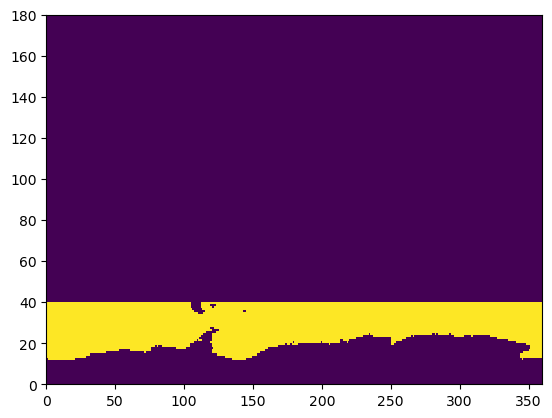

In [7]:
# basin mask
dsm=xr.open_dataset('/glade/campaign/univ/ugit0034/wod18/basin_mask_01.nc')
ma = dsm.basin_mask.isel(depth=0).to_numpy()
#
if selection[2] == '1':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==1,1,0)
elif selection[2] == '2':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==2,1,0)
elif selection[2] == '3':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where((ma==3)|(ma==56),1,0)
elif selection[2] == '4':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==10,1,0)
elif selection[2] == '5':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==11,1,0)
else:
    print('error - incorrect O2 data type')
#
plt.pcolormesh(mask)

In [8]:
dargo=xr.open_dataset(fargo)

In [9]:
#
# Obtain O2 data from observational dataset
#
Nyr=np.size(yrs)
Nt=Nyr*12
mon=["%.2d" % i for i in np.arange(1,13,1)]
#
o2=np.zeros((Nt,Nz,180,360))
#
for year in yrs:
    ytmp=year%10
    if ytmp==0:
        print(str(year))
    tr=12*(year-1965)
    timeind0=(year-2005)*12
    if (year<2005):
        ds=xr.open_dataset(dirin+var[0]+fmer+str(year)+'.nc')
        o2[tr:(tr+12),:,:,:]=ds.o2.to_numpy()
    else:
        ds=xr.open_dataset(dirin+var[0]+fmer+str(year)+'.nc')
        tmp0=ds.o2.to_numpy()
        cnt0=np.where(np.isnan(tmp0),0,1) 
        tmp1=dargo.o_mn[timeind0:timeind0+12,:,:,:].to_numpy()
        cnt1=np.where(np.isnan(tmp1),0,1)
        # if overlaps, combine ship and argo O2 data with equal weight
        tmp0=np.where(np.isnan(tmp0)==True,0,tmp0)
        tmp1=np.where(np.isnan(tmp1)==True,0,tmp1)
        o2[tr:(tr+12),:,:,:]=(tmp0*cnt0+tmp1*cnt1)/(cnt0+cnt1)

1970
1980
1990
2000
2010


In [10]:
#
# Obtain T/S data from observational gridded dataset
#
t=np.zeros((Nt,Nz,180,360))
s=np.zeros((Nt,Nz,180,360))
#
for year in yrs:
    ytmp=year%10
    if ytmp==0:
        print(str(year))
    tr=12*(year-1965)
    for mn in range(12):
        ds = xr.open_dataset(dirf+'EN4_TSN2_L09_180x360_'+str(year)+mon[mn]+'.nc')
        s[tr+mn,:,:,:]=ds.SA.interp(depth=Z).to_numpy().squeeze()
        t[tr+mn,:,:,:]=ds.CT.interp(depth=Z).to_numpy().squeeze()

1970
1980
1990
2000
2010


In [11]:
# get coordinates
x=ds.lon.to_numpy() 
# use alternative x coordinate: longitude - 20
xa0 = x - 20
xalt = np.where(xa0<0,xa0+360,xa0)
#
y=ds.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(xalt,y)
xxi,yyi=np.meshgrid(xi,yi)

In [12]:
# extract mask in the Atlantic basin
mask= dsm.basin_mask.sel(depth=Z)

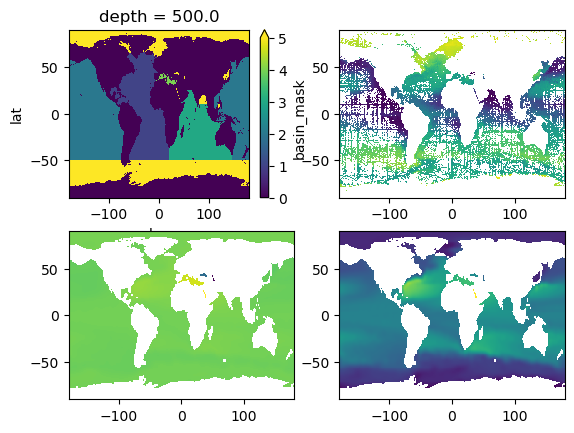

In [13]:
# take a look at the data
fig,ax=plt.subplots(2,2)
# select 500m for plotting
kind=[idx for idx,elem in enumerate(Z) if elem==500]
#
mask.isel(depth=kind).plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
ax[0,1].pcolormesh(x,y,np.nanmean(o2[:,kind[0],:,:],axis=0))
ax[1,0].pcolormesh(x,y,np.nanmean(s[:,kind[0],:,:],axis=0))
ax[1,1].pcolormesh(x,y,np.nanmean(t[:,kind[0],:,:],axis=0))

In [14]:
# make numpy array
# prepare depth lat lon time data
xx1 = np.tile(xx,[Nt,Nz,1,1])
yy1 = np.tile(yy,[Nt,Nz,1,1])
ztmp = np.tile(Z,[Nt,180,360,1])
zz1 = np.transpose(ztmp,[0,3,1,2])
t0=np.arange(0,Nt,1)
t1=t0%12
#
tt0 = np.tile(t0,[Nz,180,360,1])
tt1 = np.transpose(tt0,(3,0,1,2))
tc0 = np.tile(t1,[Nz,180,360,1])
tc1 = np.transpose(tc0,(3,0,1,2))

In [15]:
# ----------------------------------
#  apply mask 
#  basin mask is 1 for Atlantic, 2 for Pacific
# ----------------------------------
if selection[2] == '1':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    o2=np.where((ma==1),o2,np.nan)
    s=np.where((ma==1),s,np.nan)
    t=np.where((ma==1),t,np.nan)
elif selection[2] == '2':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    o2=np.where((ma==2),o2,np.nan)
    s=np.where((ma==2),s,np.nan)
    t=np.where((ma==2),t,np.nan)
elif selection[2] == '3':
    o2=np.where((ma==3)|(ma==56),o2,np.nan)
    s=np.where((ma==3)|(ma==56),s,np.nan)
    t=np.where((ma==3)|(ma==56),t,np.nan)
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '4':
    o2=np.where((ma==10),o2,np.nan)
    s=np.where((ma==10),s,np.nan)
    t=np.where((ma==10),t,np.nan)
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '5':
    o2=np.where((ma==11),o2,np.nan)
    s=np.where((ma==11),s,np.nan)
    t=np.where((ma==11),t,np.nan)
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
else:
    print('error - incorrect O2 data type')

Southern Ocean will be mapped


### Now we have the data for the selected basin. Remove NaNs and organize them into 1d array

In [16]:
# create data vector
doa0 = o2.flatten()
dsa0 = s.flatten()
dta0 = t.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()
tt0  = tt1.flatten()
tc0  = tc1.flatten()
zz0  = zz1.flatten()

In [17]:
# remove nan
dd = doa0 + dsa0 + dta0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
zz1=zz0[np.isnan(dd)==False]
tt1=tt0[np.isnan(dd)==False]
tc1=tc0[np.isnan(dd)==False]
#
Nsample = np.size(doa1)
print(Nsample)

437949


### This is where we choose what variables to include

In [18]:
# generate data matrix and standardize it
if selection[4] == '1':
    newxx1 = (yy1+90)*np.cos(np.deg2rad(xx1))
    newyy1 = (yy1+90)*np.sin(np.deg2rad(xx1))
    X = np.array([dsa1, dta1, newxx1, newyy1, zz1, tt1, tc1])
    print('Predictor variables include T, S, lon, lat, depth (pressure), year, month')
else:
    print('error - incorrect predictor variable type')    
#X = np.array([dsa1, dta1, xx1, yy1, tt1, tc1])
#
y = doa1
#
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
#
N=np.size(y)
# normalize x and y
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

Predictor variables include T, S, lon, lat, depth (pressure), year, month


## ML

### First split the data into training and test set

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,test_size=.2)

### K-fold cross validation

In [20]:
##
from sklearn.model_selection import GridSearchCV

### Algorithm selection & training

In [21]:
if alg =='RF':
    from sklearn.ensemble import RandomForestRegressor
    clf=RandomForestRegressor(n_jobs=-1)
    parameters = {'n_estimators':[100,200,500],'min_samples_leaf':[1,6,12],'max_features':[1,3]}
    regr = GridSearchCV(clf, parameters)
    regr.fit(X_train, y_train)
elif alg == 'NN':
    from sklearn.neural_network import MLPRegressor
    clf=MLPRegressor(max_iter=1000)
    parameters = {'hidden_layer_sizes':[[5,5,5,5],[10,10,10,10],[20,20,20,20],[40,40,40,40]],'alpha':[.001, .01, .1]}
    regr = GridSearchCV(clf, parameters, n_jobs = -1)
    regr.fit(X_train, y_train)

### display CV results

In [22]:
out = regr.predict(X_test)
regr.cv_results_

{'mean_fit_time': array([153.76506085]),
 'std_fit_time': array([22.86920622]),
 'mean_score_time': array([0.3918664]),
 'std_score_time': array([0.05524443]),
 'param_alpha': masked_array(data=[0.001],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([40, 40, 40, 40])],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001, 'hidden_layer_sizes': [40, 40, 40, 40]}],
 'split0_test_score': array([0.94377029]),
 'split1_test_score': array([0.94303364]),
 'split2_test_score': array([0.94309799]),
 'split3_test_score': array([0.94408865]),
 'split4_test_score': array([0.94199446]),
 'mean_test_score': array([0.94319701]),
 'std_test_score': array([0.00072198]),
 'rank_test_score': array([1], dtype=int32)}

R2 =  0.9411753678294044
RMSE =  14.232393747977191


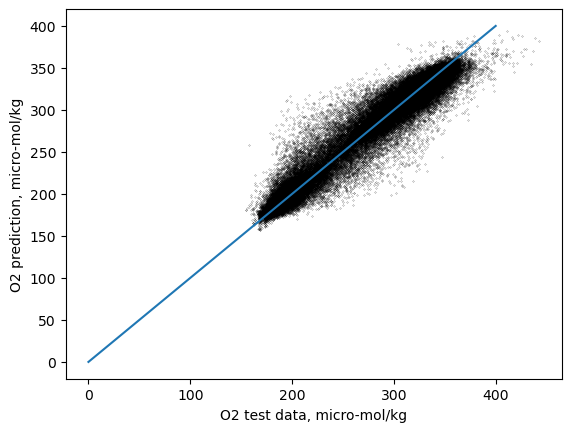

In [23]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,400],[0,400])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval=temp[0,1]
print('R2 = ',Rval**2)
RMSE=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE)
#
o2test = o2test.copy()
o2est = o2est.copy()

## Save the trained algorithm in project storage

In [24]:
import joblib
dirout='/glade/campaign/univ/ugit0034/ML4O2_results/'
# comment these out if you don't want to save the results
np.savez(dirout+f'ML_params_v{ver}.npz',Xm=Xm,Xstd=Xstd,ym=ym,ystd=ystd)
#
filename = dirout+f'algorithm_v{ver}.sav'
joblib.dump(regr, filename)
#
np.savez(dirout+f'o2test_pred_v{ver}.npz',Xtest=X_test,test=o2test,est=o2est)